In [1]:
import nltk
import string
from pprint import pprint
from nltk.corpus import brown
from gensim import corpora
from gensim.models import Word2Vec, TfidfModel
from gensim.parsing.preprocessing import remove_stopwords
from gensim import similarities
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot
from collections import defaultdict

In [2]:
%matplotlib inline

In [3]:
# nltk.download("brown")

In [4]:
def clean_sentences(sentences, use_stopwords=True):
    data = []
    space = ' '
    for sentence in sentences:
        new_sentence = space.join([word.lower() for word in sentence])
        if use_stopwords:
            new_sentence = remove_stopwords(new_sentence)
        clean_sentence = []
        for new_word in new_sentence.split():
            if new_word[0] not in string.punctuation:
                clean_sentence.append(new_word)
        if len(clean_sentence) > 0:
            data.append(space.join(clean_sentence))
    return data

In [5]:
sentences = brown.sents()

In [6]:
new_sentences = clean_sentences(sentences)

In [7]:
# remove words that appear only once
frequency = defaultdict(int)
for text in new_sentences:
    for token in text.split():
        frequency[token] += 1

texts = [
    [token for token in text.split() if frequency[token] > 1]
    for text in new_sentences
]

In [8]:
model = Word2Vec(
    sentences=texts,
    vector_size=50,
    window=10,
    epochs=20
)

In [9]:
# Finding most similar words
print("3 words similar to car")
words = model.wv.most_similar("election", topn=3)
for word in words:
  print(word)

3 words similar to car
('vote', 0.9073786735534668)
('official', 0.9039979577064514)
('charter', 0.8944346904754639)


In [10]:
words = ["france", "germany", "india", "truck", "boat", "road", "teacher", "student"]

In [11]:
X = model.wv[words]

In [12]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

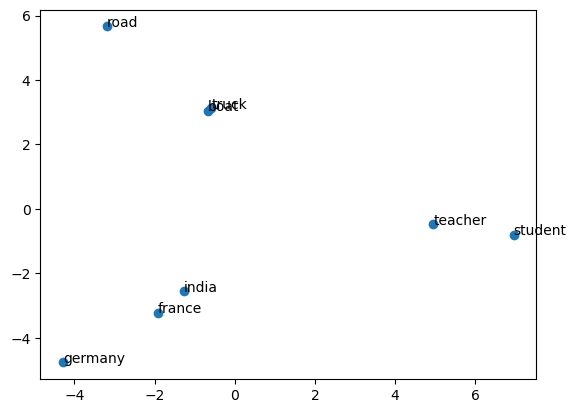

In [13]:
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [14]:
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary<27350 unique tokens: ["atlanta's", 'county', 'election', 'evidence', 'friday']...>


In [15]:
new_document = 'election ballot and voter registration'
new_vector = dictionary.doc2bow(new_document.split())
print(new_vector)

[(2, 1), (53, 1), (365, 1), (2170, 1)]


In [16]:
# each word appears 1 time in the new document
for word in new_document.split():
    try:
        res = (dictionary.token2id[word], 1)
    except KeyError:
        res = (0, 0)
    print(f'{word}: {res}')

election: (2, 1)
ballot: (365, 1)
and: (0, 0)
voter: (2170, 1)
registration: (53, 1)


In [17]:
# collection of vectors in the training data
bow_corpus = [dictionary.doc2bow(text) for text in texts]

In [18]:
tfidf = TfidfModel(bow_corpus)

In [19]:
print(tfidf[new_vector])

[(2, 0.4051067509154737), (53, 0.47910526466167225), (365, 0.5160816137578943), (2170, 0.5831007062911387)]


In [20]:
index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary.token2id))

In [21]:
query_document = 'atlanta hawks basketball team'.split()
query_vector = dictionary.doc2bow(query_document)
sims = index[tfidf[query_vector]]

In [22]:
top_n = 10
sims_list = sorted(enumerate(sims), key=lambda x: x[1], reverse=True)
for document_number, score in sims_list[:top_n]:
    print(f'Doc #{document_number} - Score: {score}')

Doc #179 - Score: 0.46595728397369385
Doc #1381 - Score: 0.39266160130500793
Doc #55266 - Score: 0.38923540711402893
Doc #55260 - Score: 0.3638986647129059
Doc #6067 - Score: 0.336804062128067
Doc #55263 - Score: 0.33241623640060425
Doc #18473 - Score: 0.30800268054008484
Doc #4037 - Score: 0.3059864342212677
Doc #15068 - Score: 0.29378369450569153
Doc #22013 - Score: 0.2923979163169861


In [23]:
' '.join(sentences[179])

'During his college career , Dr. Clark was captain of his basketball team and was a football letterman .'